#🧩 BLOQUE 1 – Descargar solo una carpeta desde GitHub en Google Colab (Sparse Checkout)

👉 Deja la carpeta DataImg lista en: /content/DataImg

Carga 1

In [2]:
# ============================================
# 1
# Descargar SOLO una carpeta desde GitHub en Google Colab (Sparse Checkout)
# Deja la carpeta lista en /content/DataImg
# ============================================

import os
import shutil
import subprocess

# 1) Variables
REPO_URL = "https://github.com/GuidoRiosCiaffaroni/Machine_Learning_II.git"
FOLDER_NAME = "DataImg/TomatoDataset_ready"
TMP_DIR = "/content/repo_temporal"

# 2) Helpers
def run(cmd, cwd=None):
    print(f"\n$ {cmd}")
    subprocess.check_call(cmd, shell=True, cwd=cwd)

def get_default_branch(repo_url):
    # Detecta rama por defecto (main / master)
    try:
        out = subprocess.check_output(
            f'git ls-remote --symref {repo_url} HEAD',
            shell=True,
            text=True
        )
        for line in out.splitlines():
            if line.startswith("ref:"):
                return line.split("refs/heads/")[-1].split("\t")[0].strip()
    except Exception:
        pass
    return "main"

# 3) Preparación: limpiar previos
shutil.rmtree(TMP_DIR, ignore_errors=True)
shutil.rmtree(f"/content/{FOLDER_NAME}", ignore_errors=True)
os.makedirs(TMP_DIR, exist_ok=True)

# 4) Detectar rama por defecto
BRANCH = get_default_branch(REPO_URL)
print(f" Rama detectada: {BRANCH}")

# 5) Inicializar repo temporal y configurar sparse checkout
run("git init", cwd=TMP_DIR)
run(f'git remote add origin "{REPO_URL}"', cwd=TMP_DIR)
run("git sparse-checkout init --cone", cwd=TMP_DIR)
run(f'git sparse-checkout set "{FOLDER_NAME}"', cwd=TMP_DIR)

# 6) Descargar solo esa carpeta
run(f'git pull --depth 1 origin "{BRANCH}"', cwd=TMP_DIR)

# 7) Mover a /content y limpiar
src_path = os.path.join(TMP_DIR, FOLDER_NAME)
dst_path = os.path.join("/content", FOLDER_NAME)

if not os.path.exists(src_path):
    raise FileNotFoundError(
        f"No se encontró la carpeta '{FOLDER_NAME}' en el repo. "
        f"Revisa que exista en la rama '{BRANCH}'."
    )

shutil.move(src_path, dst_path)
shutil.rmtree(TMP_DIR, ignore_errors=True)

print(f"\n Proceso finalizado. Carpeta lista en: {dst_path}")
print(" Archivos (primeros 30):")
print(os.listdir(dst_path)[:30])


 Rama detectada: main

$ git init

$ git remote add origin "https://github.com/GuidoRiosCiaffaroni/Machine_Learning_II.git"

$ git sparse-checkout init --cone

$ git sparse-checkout set "DataImg/TomatoDataset_ready"

$ git pull --depth 1 origin "main"

 Proceso finalizado. Carpeta lista en: /content/DataImg/TomatoDataset_ready
 Archivos (primeros 30):
['Tomato___Leaf_Mold', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Late_blight', 'Tomato___Bacterial_spot', 'Tomato___healthy', 'Tomato___Septoria_leaf_spot', 'Tomato___Early_blight']


In [3]:
Carga 2


SyntaxError: invalid syntax (ipython-input-3867580835.py, line 1)

In [ ]:
# =========================================
# 1. Importar librería para subir archivos
# =========================================
from google.colab import files

print("Selecciona el archivo ZIP desde tu computador")
uploaded = files.upload()

# =========================================
# 2. Obtener el nombre del archivo subido
# =========================================
zip_filename = list(uploaded.keys())[0]
print(f"Archivo subido: {zip_filename}")

# =========================================
# 3. Crear carpeta destino (opcional)
# =========================================
extract_path = "datos"
!mkdir -p {extract_path}

# =========================================
# 4. Descomprimir el archivo ZIP
# =========================================
!unzip -o {zip_filename} -d {extract_path}

# =========================================
# 5. Verificar contenido descomprimido
# =========================================
print("\nContenido descomprimido:")
!ls -R {extract_path}


# 🧱 BLOQUE 1: Configuración del Entorno y Hardware
Primero, asegurémonos de que tenemos las librerías necesarias y, lo más importante, que Google nos ha prestado una GPU. Sin GPU, EfficientNet tardará una eternidad.

In [4]:
# BLOQUE 1: Imports y Verificación de Hardware
import tensorflow as tf
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

# Verificar GPU
print(f"TensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f" GPU Detectada: {tf.config.experimental.get_device_details(gpus[0])['device_name']}")
    print("¡Estamos listos para acelerar!")
else:
    print(" ADVERTENCIA: No se detectó GPU. Ve a Entorno de ejecución -> Cambiar tipo de entorno -> T4 GPU.")

# Definir rutas y constantes
DATA_DIR = '/content/DataImg/TomatoDataset_ready'
IMG_SIZE = 224  # EfficientNetB0 fue entrenada con 224x224
BATCH_SIZE = 32

TensorFlow Version: 2.19.0
 ADVERTENCIA: No se detectó GPU. Ve a Entorno de ejecución -> Cambiar tipo de entorno -> T4 GPU.


#🧱 BLOQUE 2: Saneamiento del Dataset (Crucial)
Este bloque es la "magia" del profesor. Escaneará tu carpeta /content/DataImg/TomatoDataset_ready. Si encuentra las carpetas __dup1, __dup2, etc. (que son el error que detecté), moverá esas imágenes a la carpeta original correcta y borrará la carpeta duplicada.

Resultado: Pasarás de tener ~40 clases erróneas a las 10 clases correctas de enfermedades del tomate.

In [5]:
# BLOQUE 2: Limpieza y Reestructuración de Clases
def sanear_dataset(root_dir):
    print(" Iniciando saneamiento del dataset...")
    subcarpetas = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

    movidos_total = 0
    borrados_total = 0

    for folder in subcarpetas:
        # Detectar si es una carpeta duplicada (ej: Tomato___Healthy__dup1)
        if "__dup" in folder:
            original_name = folder.split("__dup")[0] # Obtiene el nombre real
            src_path = os.path.join(root_dir, folder)
            dst_path = os.path.join(root_dir, original_name)

            # Asegurar que la carpeta destino existe
            if not os.path.exists(dst_path):
                os.makedirs(dst_path)

            # Mover archivos
            files = os.listdir(src_path)
            for file in files:
                try:
                    # Renombrar para evitar colisiones si el archivo ya existe
                    new_filename = f"recovered_{borrados_total}_{file}"
                    shutil.move(os.path.join(src_path, file), os.path.join(dst_path, new_filename))
                    movidos_total += 1
                except Exception as e:
                    print(f"Error moviendo {file}: {e}")

            # Borrar carpeta duplicada vacía
            os.rmdir(src_path)
            borrados_total += 1

    print(f" Saneamiento completo.")
    print(f"   - Imágenes recuperadas: {movidos_total}")
    print(f"   - Carpetas duplicadas eliminadas: {borrados_total}")

    # Verificar clases finales
    clases_finales = sorted(os.listdir(root_dir))
    print(f" Clases finales ({len(clases_finales)}):")
    print(clases_finales)

# Ejecutar limpieza
if os.path.exists(DATA_DIR):
    sanear_dataset(DATA_DIR)
else:
    print(f" Error: No encuentro el directorio {DATA_DIR}")

 Iniciando saneamiento del dataset...
 Saneamiento completo.
   - Imágenes recuperadas: 0
   - Carpetas duplicadas eliminadas: 0
 Clases finales (10):
['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


# 🧱 BLOQUE 3: Carga Eficiente de Datos (tf.data)
Ahora cargaremos los datos usando image_dataset_from_directory. Esto crea un pipeline optimizado. Dividiremos automáticamente en 80% entrenamiento y 20% validación.

In [6]:
# BLOQUE 3: Carga del Dataset con Keras
print(" Cargando datasets...")

# Set de Entrenamiento (80%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical' # Importante para clasificación multiclase
)

# Set de Validación (20%)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

class_names = train_ds.class_names
num_classes = len(class_names)

# Optimización de caché para velocidad (Prefetching)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print(f" Datos listos. Detectadas {num_classes} clases.")

 Cargando datasets...
Found 17543 files belonging to 10 classes.
Using 14035 files for training.
Found 17543 files belonging to 10 classes.
Using 3508 files for validation.
 Datos listos. Detectadas 10 clases.


🧱 BLOQUE 4: Construcción del Modelo (Transfer Learning)
Aquí implementamos la arquitectura.

1. **Data Augmentation:** Para que el modelo generalice mejor (rotaciones, volteos).

2. **EfficientNetB0:** Usamos los pesos de 'imagenet' pero quitamos la capa superior (include_top=False).

2. **Cabezal Personalizado:** GlobalAveragePooling + Dense.

Nota Técnica: EfficientNet incluye su propia normalización interna, así que no necesitamos dividir por 255 manualmente aquí, el modelo maneja valores [0-255].

In [7]:
# BLOQUE 4: Arquitectura del Modelo
def build_efficientnet_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # 1. Aumento de datos (Solo activo durante el entrenamiento)
    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(0.1)(x)

    # 2. Base EfficientNetB0 (Pre-entrenada)
    # include_top=False quita la clasificación de 1000 clases de ImageNet
    base_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=x)

    # Congelamos la base para no dañar los pesos aprendidos al inicio
    base_model.trainable = False

    # 3. Reconstruir la salida
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x) # Reduce Overfitting

    outputs = layers.Dense(num_classes, activation="softmax", name="predicciones")(x)

    model = models.Model(inputs, outputs, name="EfficientNet_Tomato_Expert")
    return model

model = build_efficientnet_model(num_classes)
model.summary()

# Compilación
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EfficientNet_Tomato_Expert"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 224, 224,  │          0 │ random_flip[0][0] │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ random_rotation[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc

 Total params: 4,067,501 (15.52 MB)

 Trainable params: 15,370 (60.04 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

# 🧱 BLOQUE 5: Entrenamiento y Callbacks
El momento de la verdad. Usaremos Callbacks para guardar el mejor modelo automáticamente y detener el entrenamiento si deja de mejorar (Early Stopping).

 Iniciando entrenamiento...
Epoch 1/2
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.9145 - loss: 0.2700
Epoch 1: val_accuracy improved from -inf to 0.93985, saving model to mejor_modelo_tomate.keras
439/439 ━━━━━━━━━━━━━━━━━━━━ 331s 755ms/step - accuracy: 0.9145 - loss: 0.2700 - val_accuracy: 0.9399 - val_loss: 0.1745
Epoch 2/2
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.9220 - loss: 0.2346
Epoch 2: val_accuracy improved from 0.93985 to 0.95410, saving model to mejor_modelo_tomate.keras
439/439 ━━━━━━━━━━━━━━━━━━━━ 332s 756ms/step - accuracy: 0.9220 - loss: 0.2346 - val_accuracy: 0.9541 - val_loss: 0.1499


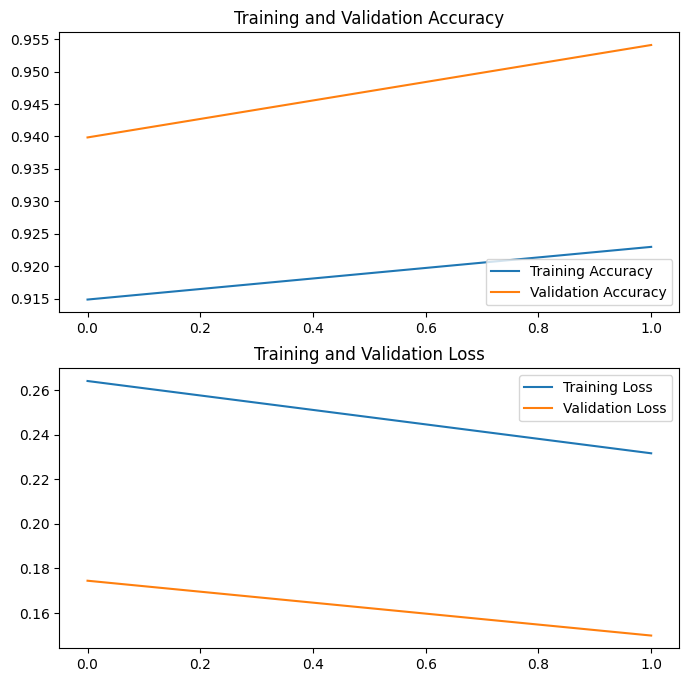

In [9]:
# BLOQUE 5: Entrenamiento
epochs = 2 # Empezamos con 2, si mejora puedes dar más

# Callbacks inteligentes
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='mejor_modelo_tomate.keras',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3, # Si no mejora en 3 épocas, para.
        restore_best_weights=True
    )
]

print(" Iniciando entrenamiento...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

# Gráfica rápida de resultados
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Bloque 6: La Matriz de Confusión.

ver visualmente en qué enfermedades está fallando tu "doctor de tomates".

 Regenerando set de validación (Correctamente aleatorizado)...
Found 17543 files belonging to 10 classes.
Using 3508 files for validation.
🔍 Extrayendo etiquetas y predicciones (esto tomará unos segundos)...
 Clases encontradas en validación: 10 de 10


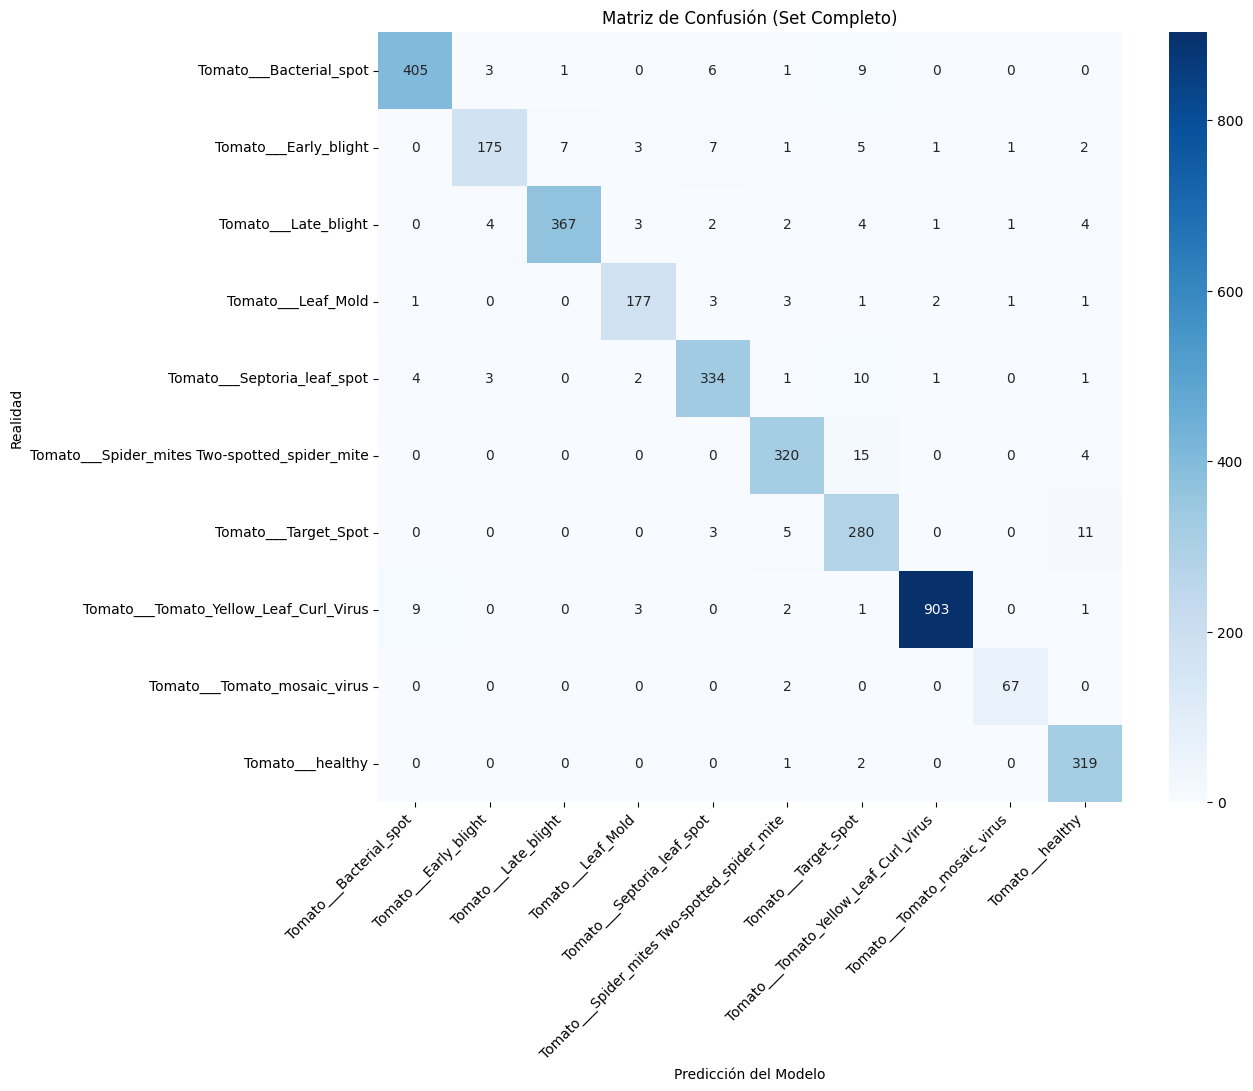


 Reporte de Clasificación Real:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.97      0.95      0.96       425
                        Tomato___Early_blight       0.95      0.87      0.90       202
                         Tomato___Late_blight       0.98      0.95      0.96       388
                           Tomato___Leaf_Mold       0.94      0.94      0.94       189
                  Tomato___Septoria_leaf_spot       0.94      0.94      0.94       356
Tomato___Spider_mites Two-spotted_spider_mite       0.95      0.94      0.95       339
                         Tomato___Target_Spot       0.86      0.94      0.89       299
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.99      0.98      0.99       919
                 Tomato___Tomato_mosaic_virus       0.96      0.97      0.96        69
                             Tomato___healthy       0.93      0.99      0.96       322

        

In [10]:
# BLOQUE 6 (VERSIÓN ROBUSTA): Evaluación Correcta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

print(" Regenerando set de validación (Correctamente aleatorizado)...")

# 1. Cargamos EXACTAMENTE igual que en el entrenamiento (con shuffle=True)
# Esto asegura que el "20%" sea una mezcla de todas las clases, no solo las últimas.
val_ds_aleatorio = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True # ¡Volvemos a True para obtener la mezcla correcta!
)

print("🔍 Extrayendo etiquetas y predicciones (esto tomará unos segundos)...")

y_true_all = []
y_pred_all = []

# Iteramos lote por lote para asegurar alineación
for images, labels in val_ds_aleatorio:
    # Predicción del modelo
    preds = model.predict(images, verbose=0)

    # Guardamos resultados
    y_pred_all.extend(np.argmax(preds, axis=1))
    y_true_all.extend(np.argmax(labels.numpy(), axis=1))

y_true = np.array(y_true_all)
y_pred = np.array(y_pred_all)

# Verificar que ahora sí están todas las clases
clases_detectadas = np.unique(y_true)
print(f" Clases encontradas en validación: {len(clases_detectadas)} de {len(class_names)}")

# 2. Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicción del Modelo')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión (Set Completo)')
plt.xticks(rotation=45, ha='right')
plt.show()

# 3. Reporte
print("\n Reporte de Clasificación Real:")
print(classification_report(y_true, y_pred, target_names=class_names))

# 🧱 BLOQUE 7: Prueba con Imágenes Nuevas (Inferencia)
Copia, pega y ejecuta. Cuando veas el botón "Elegir archivos", sube una foto de una hoja de tomate que descargues de internet (ej. busca "Tomato Early Blight" en Google).

 Sube una foto de una hoja de tomate para analizar:


Saving 0012b9d2-2130-4a06-a834-b1f3af34f57e___RS_Erly.B 8389.JPG to 0012b9d2-2130-4a06-a834-b1f3af34f57e___RS_Erly.B 8389 (1).JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


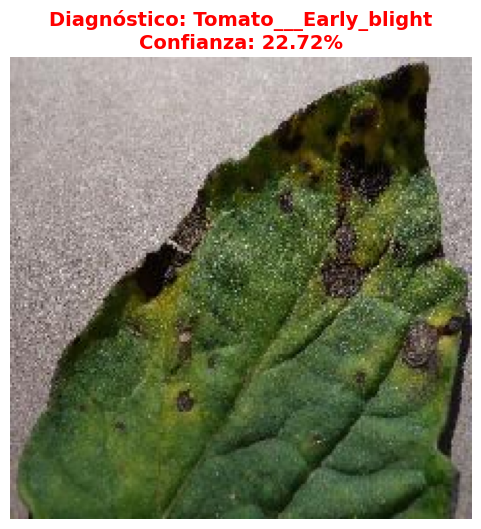

 Resultado: Tomato___Early_blight
 Advertencia: El modelo no está muy seguro. Podría ser un error.
--------------------------------------------------


In [15]:
# BLOQUE 7: Sistema de Predicción Unitaria
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from tensorflow.keras.preprocessing import image

def predecir_nueva_imagen():
    print(" Sube una foto de una hoja de tomate para analizar:")
    # Abre el widget de subida de archivos
    uploaded = files.upload()

    for fn in uploaded.keys():
        path = fn

        # 1. Cargar y preprocesar la imagen
        # IMG_SIZE debe ser 224 (definido en Bloque 1)
        img = image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0) # Crear un "lote" de una sola imagen

        # 2. Hacer la predicción
        predictions = model.predict(img_array)

        # Convertimos la salida a probabilidades (softmax)
        score = tf.nn.softmax(predictions[0])

        # 3. Obtener la clase ganadora y su confianza
        indice_ganador = np.argmax(predictions[0])
        predicted_class = class_names[indice_ganador]
        confidence = 100 * np.max(score) # Usamos score para el % real

        # 4. Mostrar resultados visualmente
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.axis('off')

        # Color del título: Verde si está muy seguro (>80%), Rojo si duda
        color_titulo = 'green' if confidence > 80 else 'red'

        plt.title(f"Diagnóstico: {predicted_class}\nConfianza: {confidence:.2f}%",
                  color=color_titulo, fontsize=14, fontweight='bold')
        plt.show()

        print(f" Resultado: {predicted_class}")
        if confidence < 70:
            print(" Advertencia: El modelo no está muy seguro. Podría ser un error.")
        print("--------------------------------------------------")

# Ejecutar la función
predecir_nueva_imagen()